# Example: Nonlinear Frame Analysis
___

## Setup

import all the needed libraries and files.

In [1]:
import numpy as np
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

from stress_strain_analysis import stress_strain_analysis
from geometry import H_beam
from mesh import Mesh
import plot_functions
import structure
import solver

## Generate the Geometry and the corresponding mesh

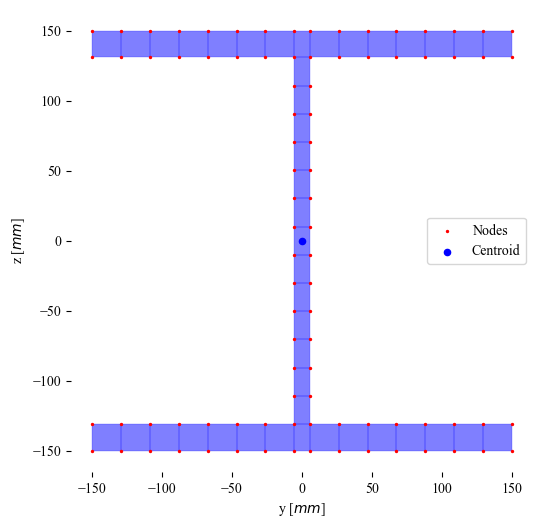

╒════════════════════╤═══════════════╕
│ Mesh Type          │ quadrilateral │
├────────────────────┼───────────────┤
│ Number of elements │ 43            │
├────────────────────┼───────────────┤
│ Number of nodes    │ 88            │
├────────────────────┼───────────────┤
│ Cross Section Area │ 14282.00      │
╘════════════════════╧═══════════════╛
╒══════════════════════════╤══════════════╤═════════════╕
│                          │            y │           z │
╞══════════════════════════╪══════════════╪═════════════╡
│ Centroid [mm]            │         0.00 │        0.00 │
├──────────────────────────┼──────────────┼─────────────┤
│ Moment of inertia [mm^4] │ 241867800.67 │ 85529060.17 │
╘══════════════════════════╧══════════════╧═════════════╛


In [2]:
# Initalize the geometry of the column
HEB_300 = H_beam(web_width     =  11.0,
                 web_height    = 262.0,
                 flange_width  = 300.0,
                 flange_height =  19.0)

# Create the mesh of the column
column = Mesh(HEB_300, mesh_type="quadrilateral", mesh_size=20)

# Print and plot the mesh of the column
column.plot()
column.print()


## Structure
Initialize the structure. For a frame, one has to define the columns and the beams geometry, the number of storeys, their width and height as well as the DOF where nodal loads will be applied and their value. 

Each node has 6 DOFs (counting starts from 0). The nodes start counting on the bottom left (0), then bottom right (1), then one storey up on the left side (2) and so on. To apply a lateral load we need the first DOF (global x-direction) of the node number 2, so therefore DOF n*6 = 2*6 = 12.

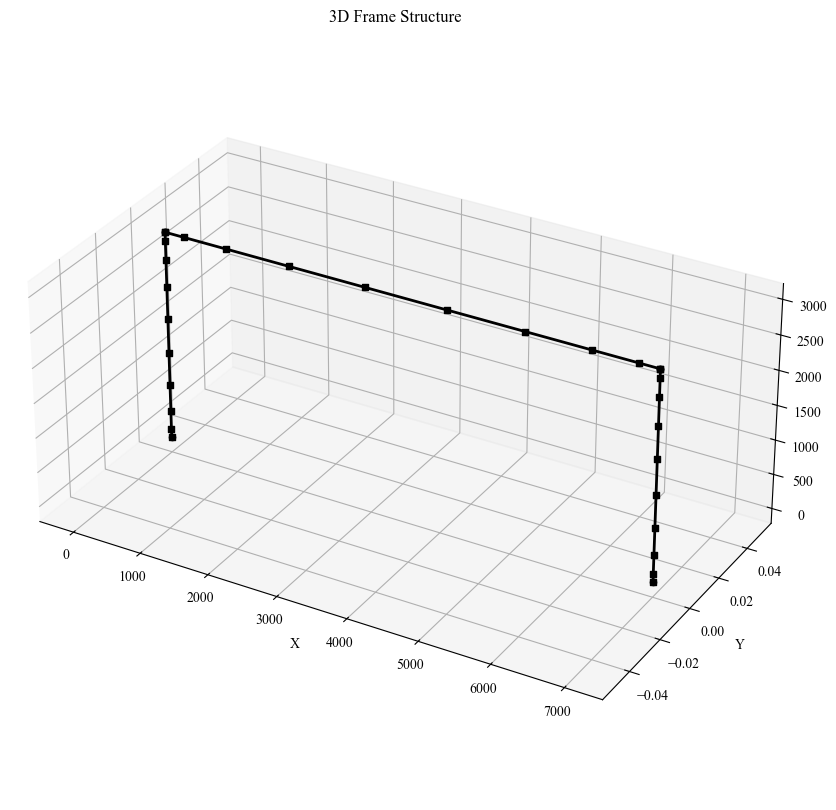

In [3]:
frame = structure.Frame(column            = column, 
						beam              = column, 
						number_of_stories = 1, 
						story_height      = 3000, 
						story_width       = 7000,
						load_DOFs         = [12],
						nodal_loads       = [1],
						number_of_sections_per_elemnt = 10)

plot_functions.plot_initial_structure(frame)

## Solver

In [4]:
non_linear_solver = solver.Nonlinear(frame, constraint="Load")

In [5]:
increments = np.zeros(140)
increments.fill(5000)

u_history, lambda_history, section_forces, section_strains = non_linear_solver.solve(increments)

  0%|          | 0/140 [00:00<?, ?it/s]

----------------------------------------------
Load step 1 of 140
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
         Beam Element  2
            Element iteration  0
         Beam Element  3
            Element iteration  0
      Residuals Norm  4.725612867034191e-10
NR Converged!
----------------------------------------------
Load step 2 of 140
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
         Beam Element  2
            Element iteration  0
         Beam Element  3
            Element iteration  0
      Residuals Norm  7.922072143711139e-11
NR Converged!
----------------------------------------------
Load step 3 of 140
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
         Beam Element  2
            Element iteration  0
         Beam Element  3
            Element iteration  0
      Residuals Norm  1.864300200552857e-09
NR Converged

## Load Displacement Curve

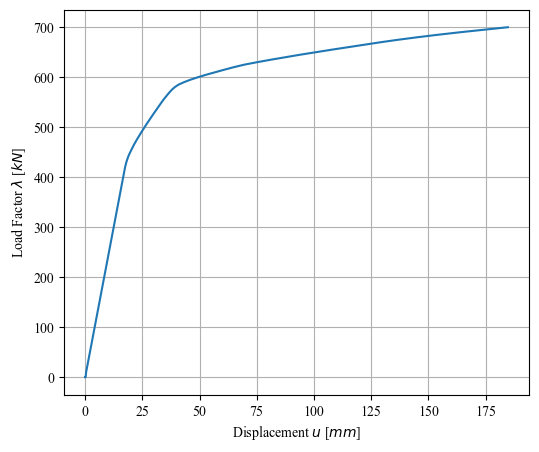

In [6]:
import matplotlib.pyplot as plt

# Main figure and axes
fig, ax = plt.subplots(figsize=(6, 5))
plt.rcParams["font.family"] = "Times New Roman"


ax.plot(u_history[:,12], lambda_history/1000,   label="Frame")
ax.set_xlabel("Displacement $u$ [$mm$]")
ax.set_ylabel("Load Factor $\\lambda$ [$kN$]")
ax.grid()

plt.show()

## Section Forces and Curvature

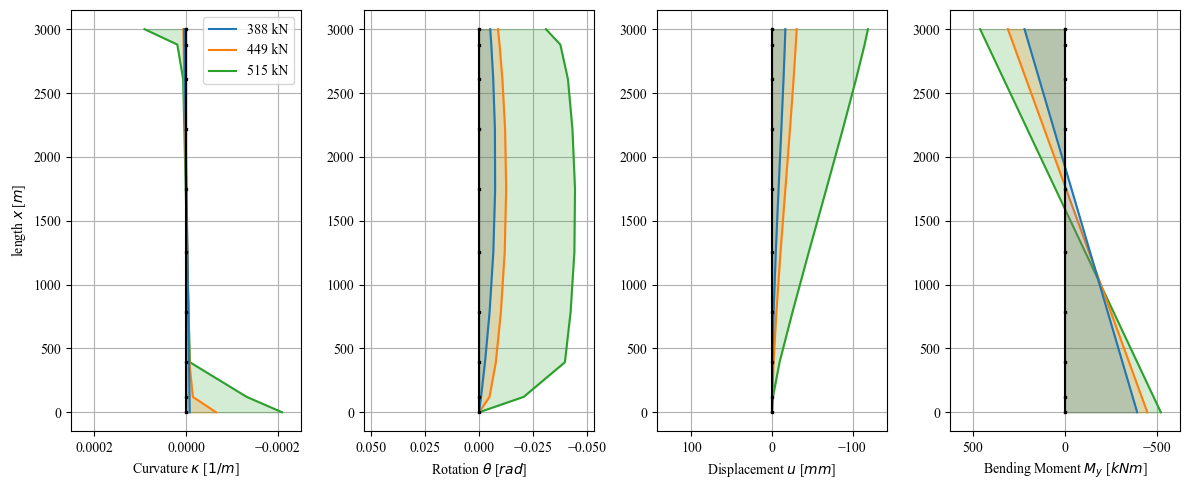

In [7]:
steps = [80, 100, 130]
plot_functions.plot_moments(steps, section_forces, section_strains, non_linear_solver, length=3000)

## Cross Section Analysis
___

### Setup Analysis

In [8]:
Analysis = stress_strain_analysis(column)

### Apply some given strains

(-2.1827872842550278e-14, 387.16040282274594, 20.90070616793813)


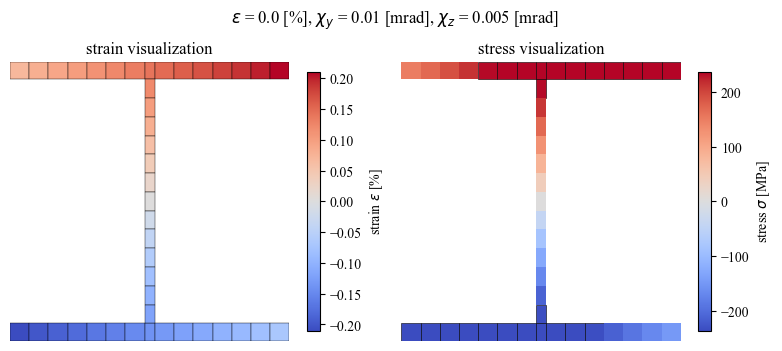

In [9]:
Analysis.set_strain_and_curvature(0.00, 0.00001, 0.000005)

Analysis.calculate_strains()
Analysis.calculate_stresses()

print(Analysis.get_section_forces())

plot_functions.plot_stress_strain_steel(Analysis)

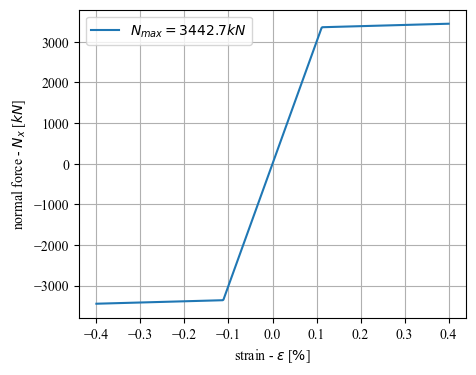

In [10]:
strains = np.linspace(-0.004, 0.004, 500)
plot_functions.plot_linear_variation_eps(Analysis, strains)

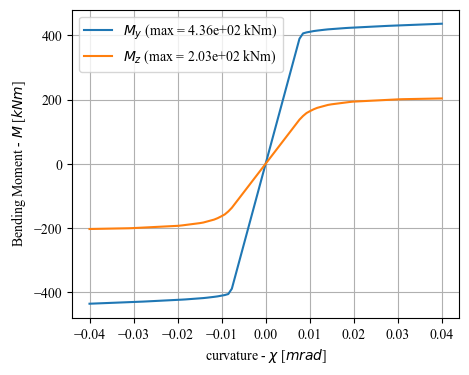

In [11]:
curvs = np.linspace(-0.00004, 0.00004, 100)
plot_functions.plot_linear_variation_curv(Analysis, curvs)

### $N-M$ and $M_y-M_z$ influence plots

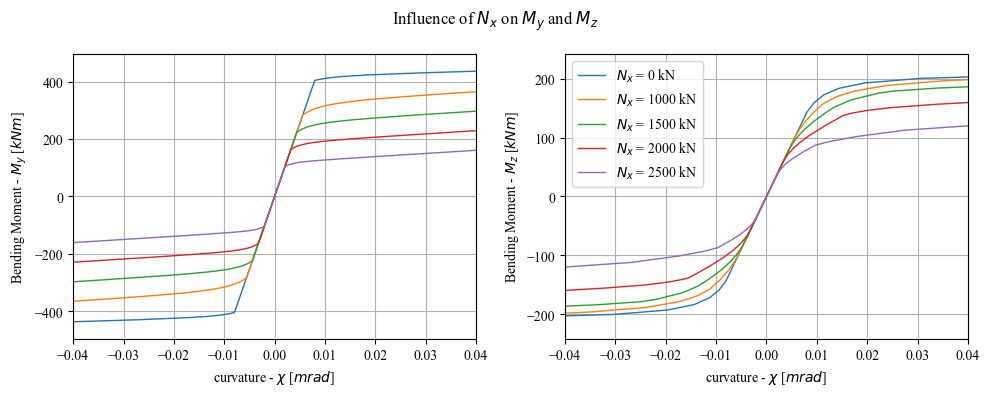

In [12]:
N = [0, 1000, 1500, 2000, 2500]
My_lim = [-450, 450]
Mz_lim = [-220, 220]
plot_functions.plot_influence_of_N_on_M(Analysis, N, My_lim, Mz_lim)

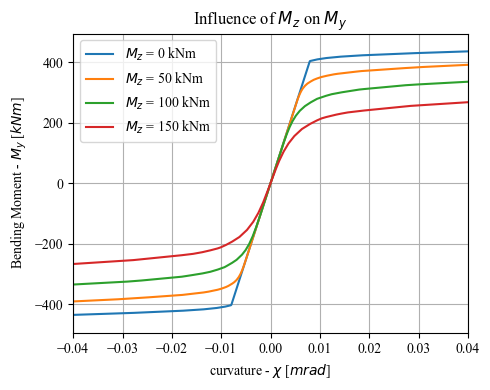

In [13]:
Mz = [0, 50, 100, 150]
My_lim = [-450, 450]
plot_functions.plot_influence_of_Mz_on_My(Analysis, My_lim, Mz)